Train 데이터 셋 분할

In [ ]:
# import os
# import pandas as pd
# from sklearn.model_selection import train_test_split

# DATA_DIR = '/data'
# ORIGIN_TRAIN_PATH = os.path.join(DATA_DIR, 'train.csv')
# SEED = 42


# df = pd.read_csv(ORIGIN_TRAIN_PATH)
# print(f"원본 데이터 개수: {len(df)}개")

# train_val, local_test = train_test_split(
#     df, test_size=0.1, stratify=df['label'], random_state=SEED
# )

# train, valid = train_test_split(
#     train_val, test_size=0.11, stratify=train_val['label'], random_state=SEED
# )

# print(f"분할 완료: Train({len(train)}) / Valid({len(valid)}) / Local_Test({len(local_test)})")

# train.to_csv(os.path.join(DATA_DIR, 'train_fixed.csv'), index=False)
# valid.to_csv(os.path.join(DATA_DIR, 'valid_fixed.csv'), index=False)
# local_test.to_csv(os.path.join(DATA_DIR, 'local_test_fixed.csv'), index=False)

# print("데이터 분할 및 저장 완료")

특수 기호 제거 로직

In [ ]:
import os
import re
import pandas as pd
from pathlib import Path

# ==========================================
#  1. 경로 및 설정 (pathlib 적용)
# ==========================================
# 현재 작업 경로(Project Root)를 기준으로 경로를 잡음. 정상적인 경우 make-model이 베이스폴더가 됨
PROJECT_ROOT = Path.cwd()
# 입력 데이터 경로 (원본)
INPUT_DIR = PROJECT_ROOT / 'data' / 'raw'
INPUT_FILE_NAME = 'train.csv'


# 출력 데이터 경로 (저장용) - interim 폴더로 분리
OUTPUT_DIR = PROJECT_ROOT / 'data' / 'interim'
OUTPUT_FILE_NAME = 'clean_train.csv'

# ==========================================
#  2. Cleaning 함수 정의
# ==========================================
def clean_text(text):
    if not isinstance(text, str):
        text = str(text)

    # 1. HTML 태그 제거
    text = re.sub(r'<[^>]+>', '', text)

    # 2. 한자 제거
    text = re.sub(r'[\u4E00-\u9FFF]', '', text)

    # 3. 빈 괄호 및 내용 없는 괄호 패턴 제거
    text = re.sub(r'\(\s*[^\w가-힣]*\s*\)', '', text)

    # 4. ( ? ~ ? ) 형태의 특정 노이즈 패턴 제거
    text = re.sub(r'\([^\(\)]{0,20}[\?\~]{1,3}[^\(\)]{0,20}\)', '', text)

    # 5. 반복되는 점(...) 정제 -> 점(.) 하나로 변경
    text = re.sub(r'[.,]{3,}', '.', text)

    # 6. 반복되는 쉼표(,,,) 정제 -> 쉼표(,) 하나로 변경
    text = re.sub(r',\s*,+', ',', text)

    # 7. 중복 괄호((())) 정제 -> 괄호 하나로 변경
    text = re.sub(r'\({2,}', '(', text)
    text = re.sub(r'\){2,}', ')', text)

    # 8. 다중 공백 제거 (하나의 공백으로)
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# ==========================================
#  3. 데이터 로드 함수
# ==========================================
def load_data(path):
    if not path.exists():
        print(f"파일이 존재하지 않음: {path}")
        return None
    
    encodings = ['utf-8', 'utf-8-sig', 'cp949']
    df = None
    
    for enc in encodings:
        try:
            df = pd.read_csv(path, encoding=enc)
            print(f"데이터 로드 성공 ({enc}): {path.name}")
            break
        except Exception:
            continue
            
    if df is None:
        print("데이터 로드 실패 (인코딩 문제일 수 있음)")
    return df

# ==========================================
#  4. 메인 실행 함수
# ==========================================
def main():
    input_path = INPUT_DIR / INPUT_FILE_NAME
    
    print("-" * 40)
    print(f"읽어올 경로: {input_path}")
    
    df = load_data(input_path)
    if df is None:
        return

    text_col = 'full_text' 
    if 'full_text' not in df.columns:
        for candidate in ['text', 'paragraph_text', 'content']:
            if candidate in df.columns:
                text_col = candidate
                break
    
    print(f"텍스트 컬럼 감지됨: '{text_col}'")
    print("데이터 정제 시작...")

    # 3. [리포트용] 변경 전 데이터 백업
    original_col = f"{text_col}_original"
    df[original_col] = df[text_col]

    # 4. 정제 수행
    df[text_col] = df[text_col].apply(clean_text)

    # 5. [리포트용] 실제로 내용이 바뀐 행만 추출
    changed_df = df[df[original_col] != df[text_col]]
    
    # --- 결과 리포트 출력 ---
    print("\n" + "="*30)
    print("      정제 결과 리포트      ")
    print("="*30)
    print(f"총 데이터 개수 : {len(df)}개")
    print(f"변경된 데이터  : {len(changed_df)}개 ({(len(changed_df)/len(df))*100:.2f}%)")
    
    if len(changed_df) > 0:
        print("\n[변경 예시 Top 3]")
        for i, row in changed_df.head(3).iterrows():
            print(f"전: {row[original_col]}")
            print(f"후: {row[text_col]}")
            print("-" * 20)
    else:
        print("\n(이미 깨끗해서 변경된 내용이 없습니다)")

    # 6. 빈 문자열 제거
    initial_len = len(df)
    df = df[df[text_col].str.strip() != ""]
    removed_count = initial_len - len(df)
    
    if removed_count > 0:
        print(f"\n정제 후 빈 문자열이 되어 제거된 행: {removed_count}개")

    # 7. 임시 컬럼 삭제
    df.drop(columns=[original_col], inplace=True)

    # 8. 저장 경로 설정 (폴더 없으면 자동 생성)
    output_path = OUTPUT_DIR / OUTPUT_FILE_NAME
    
    # 부모 폴더(processed)가 없으면 생성
    OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
    
    # 저장
    df.to_csv(output_path, index=False, encoding='utf-8-sig')
    
    print("\n" + "="*30)
    print(f"저장 완료!")
    print(f"저장 경로: {output_path}")
    print("="*30)

if __name__ == "__main__":
    main()

----------------------------------------
읽어올 경로: c:\Users\ghdrm\OneDrive\바탕 화면\git\make-model\data\raw\train.csv
데이터 로드 성공 (utf-8): train.csv
텍스트 컬럼 감지됨: 'full_text'
데이터 정제 시작...

      정제 결과 리포트      
총 데이터 개수 : 97172개
변경된 데이터  : 97041개 (99.87%)

[변경 예시 Top 3]
전: 카호올라웨섬은 하와이 제도를 구성하는 8개의 화산섬 가운데 하나로 면적은 115.5km2, 높이는 452m이다. 하와이 제도에서 가장 작은 화산섬이자 무인도이며 길이는 18km, 너비는 10km이다. 
 마우이섬에서 남서쪽으로 약 11km 정도 떨어진 곳에 위치하며 라나이섬의 남동쪽에 위치한다. 고도가 낮고 북동쪽에서 불어오는 무역풍을 통해 산악 지대에서 내리는 비를 형성하지 못하기 때문에 건조한 기후를 띤다. 마우이섬 화산의 비그늘에 속해 있기 때문에 섬 전체 면적의 1/4 이상이 부식되어 있다. 
 1000년경부터 사람이 거주했으며 해안 지대에는 소규모 임시 어촌이 형성되었다. 섬 안에는 주민들이 돌로 만든 제단에서 종교 의식을 거행한 흔적들, 주민들이 암석이나 평평한 돌에 그림을 그린 흔적들이 남아 있다. 1778년부터 1800년대까지 이 지역을 지나 항해하던 사람들의 보고에 따르면 카호올라웨섬은 무인도였고 나무도 물도 없는 불모지였다고 한다. 
 1830년대에는 하와이 왕국의 카메하메하 3세 국왕에 의해 남자 죄수들의 유형지로 사용되었지만 1853년에 폐지되었다. 1858년에는 하와이 정부가 목장 사업가들에게 카호올라웨섬을 양도했지만 가뭄과 과도한 방목으로 인해 땅이 말라갔다. 또한 강한 무역풍으로 인해 표토의 대부분이 날아가면서 붉은 경반층만 남게 되었다. 
 1910년부터 1918년까지 하와이 준주가 섬의 원래 모습을 복원하기 위해 이 섬을 천연보호구역으로 지정했지만 큰 성과를 거두지

4fold용 데이터셋 분할
1. train -> 0.9 : 0.1(train / test)
2. 4fold 0.75 : 0.25(train / valid)

In [5]:
import os
import pandas as pd
import csv
import numpy as np
from pathlib import Path
from sklearn.model_selection import StratifiedKFold, train_test_split

# ==========================================
#  1. 경로 및 설정 (pathlib 적용)
# ==========================================
PROJECT_ROOT = Path.cwd()

INPUT_DIR = PROJECT_ROOT / 'data' / 'interim'
INPUT_FILE_NAME = 'clean_train_balanced.csv'

# 출력 경로: Fold 데이터가 저장될 위치 ('data/fold')
OUTPUT_ROOT_DIR = PROJECT_ROOT / 'data' / 'fold'

# 저장될 파일 이름 설정
OUTPUT_TEST_FILENAME = 'local_balanced_test.csv' 
OUTPUT_TRAIN_FILENAME = 'balanced_train.csv'       
OUTPUT_VALID_FILENAME = 'balanced_valid.csv'       

SEED = 42
detected_delimiter = ','
detected_quotechar = '"'

# ==========================================
#  2. 유틸리티 함수
# ==========================================

def find_column_name(columns, candidates):
    for col in columns:
        if col.lower().strip() in candidates:
            return col
    return None

def load_and_fix_data(path, is_test=False):
    # pathlib 객체 호환 처리
    if not path.exists():
        print(f"파일이 없음: {path}")
        return None

    df = None
    encodings_to_try = ['utf-8-sig', 'utf-8', 'cp949']

    for encoding in encodings_to_try:
        try:
            df = pd.read_csv(
                path,
                encoding=encoding,
                engine='python',
                on_bad_lines='skip',
                encoding_errors='ignore',
                delimiter=detected_delimiter,
                quotechar=detected_quotechar,
                quoting=csv.QUOTE_MINIMAL
            )
            break
        except Exception as e:
            df = None

    if df is None:
        print(f"데이터 로드 실패: {path}")
        return None

    # 컬럼명 정리 (text)
    text_candidates = ['paragraph_text', 'text', 'sentence', 'content', 'full_text']
    text_col = find_column_name(df.columns, text_candidates)
    if text_col:
        df.rename(columns={text_col: 'text'}, inplace=True)
    else:
        obj_cols = df.select_dtypes(include=['object']).columns
        if len(obj_cols) > 0:
            df.rename(columns={obj_cols[0]: 'text'}, inplace=True)
        else:
            return None

    # 컬럼명 정리 (id) - Test셋일 경우
    if is_test:
        id_candidates = ['id', 'idx', 'index', 'no', 'ID']
        id_col = find_column_name(df.columns, id_candidates)
        if id_col:
            df.rename(columns={id_col: 'id'}, inplace=True)
        else:
            df['id'] = df.index

    # 컬럼명 정리 (label) - Train셋일 경우
    if not is_test:
        target_candidates = ['generated', 'label', 'target', 'class']
        target_col = find_column_name(df.columns, target_candidates)
        if target_col:
            df.rename(columns={target_col: 'label'}, inplace=True)
            try:
                df['label'] = df['label'].astype(int)
            except:
                pass
        else:
            print("타겟(Label) 컬럼을 찾을 수 없습니다.")
            return None

    return df

def create_split_and_kfold(input_path, output_root, n_splits=4, test_size=0.1):
    print(f"-" * 40)
    print(f">>> 데이터 분할 작업 시작")
    print(f"입력 파일: {input_path}")
    print(f"출력 폴더: {output_root}")
    print(f"설정: Fold={n_splits}, Test Size={test_size}")
    print(f"-" * 40)
    
    # 1. 원본 데이터 로드
    df = load_and_fix_data(input_path, is_test=False)
    
    if df is None:
        print("데이터 로드 실패로 작업을 중단합니다.")
        return

    print(f"데이터 로드 완료: {len(df)}개 행")

    # 출력 루트 폴더 생성 (pathlib mkdir 사용)
    output_root.mkdir(parents=True, exist_ok=True)

    # 2. [Test Set 분리]
    print(f"\n[Step 1] Test Set 분리 (비율: {test_size})")
    dev_df, test_df = train_test_split(
        df, 
        test_size=test_size, 
        stratify=df['label'], 
        random_state=SEED,
        shuffle=True
    )
    
    # Test Set 저장
    test_save_path = output_root / OUTPUT_TEST_FILENAME
    test_df.to_csv(test_save_path, index=False)
    
    print(f" -> Test Set 저장 완료: {test_save_path.name}")
    print(f"    (Size: {len(test_df)}, Label 0: {(test_df['label']==0).sum()}, Label 1: {(test_df['label']==1).sum()})")

    # 3. [K-Fold 분할 및 폴더별 저장]
    print(f"\n[Step 2] {n_splits}-Fold Cross Validation 데이터 생성")
    
    dev_df = dev_df.reset_index(drop=True)
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)

    for fold, (train_idx, val_idx) in enumerate(skf.split(dev_df, dev_df['label'])):
        fold_train_df = dev_df.iloc[train_idx]
        fold_val_df = dev_df.iloc[val_idx]
        
        # 폴더 경로 생성 (fold0, fold1 ...)
        fold_dir_name = f'fold{fold}'
        current_fold_dir = output_root / fold_dir_name
        
        # 폴더 생성
        current_fold_dir.mkdir(parents=True, exist_ok=True)
        
        # 파일 저장
        train_save_path = current_fold_dir / OUTPUT_TRAIN_FILENAME
        val_save_path = current_fold_dir / OUTPUT_VALID_FILENAME
        
        fold_train_df.to_csv(train_save_path, index=False)
        fold_val_df.to_csv(val_save_path, index=False)
        
        print(f" -> [{fold_dir_name}] 저장 완료")
        # 상세 정보는 너무 길어질 수 있으니 필요하면 주석 해제
        # print(f"      Train: {len(fold_train_df)}개, Valid: {len(fold_val_df)}개")

    print("\n>>> 모든 작업이 완료됨.")
    print(f"최종 결과물 위치: {output_root}")

if __name__ == "__main__":
    # 실행 경로 조합
    input_full_path = INPUT_DIR / INPUT_FILE_NAME
    
    create_split_and_kfold(
        input_path=input_full_path, 
        output_root=OUTPUT_ROOT_DIR, 
        n_splits=4, 
        test_size=0.1
    )

ModuleNotFoundError: No module named 'sklearn'

ai특징

문단별로 ~다. ~임. ~함. (격식체 오류)
이에 따라, 또한(논리적 오류)
~등 다양한, ~에 대한(설명 오류)

In [ ]:
import pandas as pd
import numpy as np
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

FILE_PATH = '/home/user/rocm_project/make-model/data/fold/fold0/origin_train.csv'

# ==========================================
# 어미 분석 함수
# ==========================================
def analyze_style(text):

    if not isinstance(text, str):
        return 0.0
    
    # 문장 분리 (. ? ! 기준으로 나눔)
    sentences = re.split(r'(?<=[.?!])\s+', text)
    sentences = [s.strip() for s in sentences if len(s) > 1]
    
    if not sentences:
        return 0.0
    
    # 특정 어미로 끝나는 문장 카운트
    # '다.', '다' / '임.', '임' / '함.', '함' 등을 모두 체크
    pattern_count = 0
    for s in sentences:
        if s.endswith(('다.', '다', '임.', '임', '함.', '함')):
            pattern_count += 1
            
    # 전체 문장 중 해당 패턴의 비율 (0.0 ~ 1.0)
    return pattern_count / len(sentences)

# ==========================================
# 3. 분석 실행
# ==========================================
def run_analysis():
    if not os.path.exists(FILE_PATH):
        print(f"파일을 찾을 수 없습니다: {FILE_PATH}")
        return

    print(f"데이터 로드 중... ({FILE_PATH})")
    df = pd.read_csv(FILE_PATH)
    
    # 텍스트 컬럼 찾기
    if 'text' not in df.columns:
        # 유사 컬럼명 검색
        for col in df.columns:
            if col in ['paragraph_text', 'content', 'full_text']:
                df.rename(columns={col: 'text'}, inplace=True)
                break
    
    print("🚀 어미 패턴 분석 시작 (시간이 조금 걸릴 수 있습니다)...")
    # 'style_ratio': 전체 문장 중 '다/임/함'으로 끝나는 문장의 비율
    df['style_ratio'] = df['text'].apply(analyze_style)
    
    # 구간(Bin) 나누기: 10% 단위로 구간화
    # 예: 0.0~0.1, 0.1~0.2, ... 0.9~1.0
    bins = [0.0, 0.1, 0.3, 0.5, 0.7, 0.9, 1.01]
    labels = ['0~10%', '10~30%', '30~50%', '50~70%', '70~90%', '90~100%']
    df['ratio_group'] = pd.cut(df['style_ratio'], bins=bins, labels=labels, right=False)
    
    print("\n" + "="*50)
    print("[분석 결과] '다/임/함' 말투 비율에 따른 통계")
    print("="*50)

    # 그룹별 통계 계산
    # 'label'이 있으면 실제 AI 비율을, 'prob_1'이 있으면 모델 예측 확률을 계산
    agg_dict = {'text': 'count'} # 샘플 수
    
    if 'label' in df.columns:
        agg_dict['label'] = 'mean' # 실제 AI 비율 (Ground Truth)
        
    if 'prob_1' in df.columns: # 예측 결과 파일인 경우
        agg_dict['prob_1'] = 'mean' # 모델이 예측한 AI 확률
    elif 'ensemble_prob_1' in df.columns:
        agg_dict['ensemble_prob_1'] = 'mean'

    grouped = df.groupby('ratio_group', observed=False).agg(agg_dict)
    
    # 컬럼 이름 보기 좋게 변경
    rename_map = {'text': 'Sample Count'}
    if 'label' in agg_dict: rename_map['label'] = 'Actual AI Ratio'
    if 'prob_1' in agg_dict: rename_map['prob_1'] = 'Predicted AI Prob'
    if 'ensemble_prob_1' in agg_dict: rename_map['ensemble_prob_1'] = 'Predicted AI Prob'
    
    grouped = grouped.rename(columns=rename_map)
    print(grouped)
    
    # -------------------------------------------------------
    # 시각화 (선택 사항)
    # -------------------------------------------------------
    # Actual AI Ratio가 존재하면 그래프를 그림
    if 'Actual AI Ratio' in grouped.columns:
        print("\n[해석]")
        high_ratio_group = grouped.loc['90~100%', 'Actual AI Ratio']
        low_ratio_group = grouped.loc['0~10%', 'Actual AI Ratio']
        
        print(f" - '다/임/함' 도배된 글(90%↑)의 실제 AI 비율: {high_ratio_group*100:.1f}%")
        print(f" - 그런 말투가 없는 글(10%↓)의 실제 AI 비율: {low_ratio_group*100:.1f}%")
        
        if high_ratio_group < 0.2: # 예: 설명문인데 AI 비율이 낮다면
            print("result: '설명문 말투'를 쓰는 데이터의 대다수는 0")
        elif high_ratio_group > 0.8:
            print("result: 이 데이터셋에서는 '설명문 말투'는 대부분 AI가 쓴 것이 맞음")
            
if __name__ == "__main__":
    run_analysis()

📂 데이터 로드 중... (/home/user/rocm_project/make-model/data/fold/fold0/origin_train.csv)
🚀 어미 패턴 분석 시작 (시간이 조금 걸릴 수 있습니다)...

📊 [분석 결과] '다/임/함' 말투 비율에 따른 통계
             Sample Count  Actual AI Ratio
ratio_group                               
0~10%                  38         0.000000
10~30%                 53         0.018868
30~50%                143         0.195804
50~70%               1014         0.297830
70~90%               7774         0.304605
90~100%             56568         0.047677

📈 [해석]
 - '다/임/함' 도배된 글(90%↑)의 실제 AI 비율: 4.8%
 - 그런 말투가 없는 글(10%↓)의 실제 AI 비율: 0.0%
🚨 중요 발견: '설명문 말투'를 쓰는 데이터의 대다수는 '사람(0)'입니다!
   -> 모델이 이 말투를 AI로 착각하고 있다면, 이것이 가장 큰 오답 원인입니다.


데이터 축소 작업
Base: clean_train.csv
method: 

In [ ]:
import pandas as pd
import numpy as np
import re
import sys
from pathlib import Path

# =============
# 1. 설정 
# =============
PROJECT_ROOT = Path.cwd()

INPUT_PATH = PROJECT_ROOT / 'data' / 'interim' / 'clean_train.csv'
OUTPUT_PATH = PROJECT_ROOT / 'data' / 'interim' / 'clean_train_balanced.csv'

# 목표 비율 (Human : AI = 3 : 1)
TARGET_RATIO = 3.0  

# ==========================================
# 2. 유틸리티 함수
# ==========================================
def analyze_style_score(text):

    if not isinstance(text, str): return 0.0
    
    sentences = re.split(r'(?<=[.?!])\s+', text)
    sentences = [s.strip() for s in sentences if len(s) > 1]
    
    if not sentences: return 0.0
    
    # AI스러운 어미 패턴
    ai_like_count = 0
    for s in sentences:
        # 설명문 말투 (~다, ~임, ~함)
        if s.endswith(('다.', '다', '임.', '임', '함.', '함')):
            ai_like_count += 1
        # 논리적 연결어 (가중치 추가)
        if any(x in s for x in ['따라서', '또한', '이에', '즉', '의미한다']):
            ai_like_count += 0.5 
            
    return min(1.0, ai_like_count / len(sentences))

def smart_downsampling(df):
    print(f"[Downsampling] 시작")
    print(f"   원본 데이터: {len(df)}개")
    print(f"   - Label 0 (Human): {len(df[df['label']==0])}")
    print(f"   - Label 1 (AI):    {len(df[df['label']==1])}")
    
    # 1. 클래스 분리
    df_human = df[df['label'] == 0].copy()
    df_ai = df[df['label'] == 1].copy()
    
    # 2. 목표 개수 계산
    n_ai = len(df_ai)
    target_human_count = int(n_ai * TARGET_RATIO)
    
    if len(df_human) <= target_human_count:
        print("   이미 비율이 목표보다 좋거나 데이터가 적어서 축소하지 않습니다.")
        return df
    
    print(f"   목표: Human 데이터를 {len(df_human)} -> {target_human_count}개로 축소 (비율 {TARGET_RATIO}:1)")
    
    # 3. 중요도 점수 계산
    print("   중요도(Style Score) 계산 중...")
    df_human['style_score'] = df_human['text'].apply(analyze_style_score)
    
    # 4. 데이터 선별 전략
    # - Top Tier (상위 60%): 설명문 스타일 -> 유지 (Hard Negative)
    # - Bottom Tier (하위 40%): 대화체/쉬운글 -> 랜덤 삭제 (Easy Negative)
    
    df_human = df_human.sort_values(by='style_score', ascending=False)
    
    keep_n_high = int(target_human_count * 0.6) 
    keep_n_low = target_human_count - keep_n_high
    
    high_score_group = df_human.iloc[:keep_n_high]
    low_score_group = df_human.iloc[keep_n_high:]
    
    # 하위 그룹에서 랜덤 샘플링
    if len(low_score_group) > keep_n_low:
        low_score_sampled = low_score_group.sample(n=keep_n_low, random_state=42)
    else:
        low_score_sampled = low_score_group
        
    # 합치기
    df_human_balanced = pd.concat([high_score_group, low_score_sampled])
    
    # 최종 데이터셋 생성
    final_df = pd.concat([df_human_balanced, df_ai]).sample(frac=1, random_state=42).reset_index(drop=True)
    
    # 결과 리포트
    avg_score_before = df_human['style_score'].mean()
    avg_score_after = df_human_balanced['style_score'].mean()
    
    print(f"   축소 완료: {len(final_df)}개")
    print(f"   - Label 0 평균 Style 점수: {avg_score_before:.3f} -> {avg_score_after:.3f} (어려운 데이터 위주로 남김)")
    
    if 'style_score' in final_df.columns:
        del final_df['style_score']
        
    return final_df

# ==========================================
# 3. 메인 실행
# ==========================================
if __name__ == "__main__":
    # Path 객체이므로 exists() 확인 가능
    if not INPUT_PATH.exists():
        print(f"입력 파일이 없습니다: {INPUT_PATH}")
        print(f"현재 실행 위치(CWD)를 확인해주세요: {PROJECT_ROOT}")
        sys.exit()

    print(f"데이터 로드 중... {INPUT_PATH}")
    try:
        df = pd.read_csv(INPUT_PATH)
    except:
        df = pd.read_csv(INPUT_PATH, encoding='cp949')

    print(f"   원본 컬럼 목록: {list(df.columns)}")

    # ---------------------------------------------------------
    # 텍스트 컬럼 자동 매칭
    # ---------------------------------------------------------
    text_col = None
    text_candidates = ['text', 'paragraph_text', 'content', 'sentence', 'full_text', 'overview', 'document']
    
    for col in df.columns:
        if col.lower() in text_candidates:
            text_col = col
            break
            
    if text_col is None:
        obj_cols = df.select_dtypes(include=['object']).columns
        if len(obj_cols) > 0:
            text_col = obj_cols[0]

    if text_col:
        print(f"   텍스트 컬럼 확인: '{text_col}' -> 'text'로 변경")
        df.rename(columns={text_col: 'text'}, inplace=True)
    else:
        print("[Error] 텍스트 컬럼을 찾을 수 없습니다. CSV 헤더를 확인해주세요.")
        sys.exit()

    # ---------------------------------------------------------
    # 라벨 컬럼 자동 매칭
    # ---------------------------------------------------------
    label_col = None
    label_candidates = ['label', 'generated', 'target', 'class', 'answer']
    
    for col in df.columns:
        if col.lower() in label_candidates:
            label_col = col
            break
            
    if label_col:
        print(f"   라벨 컬럼 확인: '{label_col}' -> 'label'로 변경")
        df.rename(columns={label_col: 'label'}, inplace=True)
    else:
        print("[Error] 라벨(정답) 컬럼을 찾을 수 없습니다.")
        sys.exit()

    # ---------------------------------------------------------
    # 실행
    # ---------------------------------------------------------  
    balanced_df = smart_downsampling(df)
    
    # 저장 폴더가 없으면 생성 (Path 객체의 parent 속성 사용)
    OUTPUT_PATH.parent.mkdir(parents=True, exist_ok=True)
    
    balanced_df.to_csv(OUTPUT_PATH, index=False)
    print(f"저장 완료: {OUTPUT_PATH}")

데이터 로드 중... c:\Users\ghdrm\OneDrive\바탕 화면\git\make-model\data\interim\clean_train.csv
   원본 컬럼 목록: ['title', 'full_text', 'generated']
   텍스트 컬럼 확인: 'full_text' -> 'text'로 변경
   ✅ 라벨 컬럼 확인: 'generated' -> 'label'로 변경
[Downsampling] 시작
   원본 데이터: 97172개
   - Label 0 (Human): 89177
   - Label 1 (AI):    7995
   목표: Human 데이터를 89177 -> 23985개로 축소 (비율 3.0:1)
   중요도(Style Score) 계산 중...
   축소 완료: 31980개
   - Label 0 평균 Style 점수: 0.975 -> 0.989 (어려운 데이터 위주로 남김)
저장 완료: c:\Users\ghdrm\OneDrive\바탕 화면\git\make-model\data\interim\clean_train_balanced.csv


수행 완료 시, 위에 fold 분할을 다시 해주세요.

아래코드는 4000토큰을 초과하는 데이터를 자름.

In [ ]:
import os
import pandas as pd
from transformers import AutoTokenizer
from tqdm import tqdm

# ==========================================
# [1] 설정
# ==========================================
BASE_DIR = 'data/interim/'
INPUT_FILENAME = 'clean_train_balanced.csv'
OUTPUT_FILENAME = 'clean_train_balanced_under4000.csv' # 저장할 파일명
MODEL_NAME = "monologg/koelectra-small-v3-discriminator"
MAX_TOKEN_LIMIT = 4000  # 제거 기준 (이 값보다 크면 삭제)

def main():
    print("데이터 길이 필터링(Outlier Removal) 시작...")
    
    # 1. 파일 로드
    file_path = os.path.join(BASE_DIR, INPUT_FILENAME)
    if not os.path.exists(file_path):
        print(f"파일을 찾을 수 없습니다: {file_path}")
        return
        
    df = pd.read_csv(file_path)
    original_len = len(df)
    print(f" -> 원본 데이터 개수: {original_len:,} 개")

    # 2. 토크나이저 로드
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    
    # 3. 토큰 길이 계산 (progress_apply 사용)
    # tqdm을 pandas에 적용
    tqdm.pandas()
    
    print(f" -> 토큰 길이 계산 중... (기준: {MAX_TOKEN_LIMIT} 토큰)")
    
    # text 컬럼을 문자열로 변환 후 토큰 길이 계산
    df['token_len'] = df['text'].astype(str).progress_apply(
        lambda x: len(tokenizer.encode(x, add_special_tokens=True))
    )
    
    # 4. 필터링 (4000토큰 이하만 남김)
    df_filtered = df[df['token_len'] <= MAX_TOKEN_LIMIT].copy()
    
    # 제거된 개수 확인
    removed_count = original_len - len(df_filtered)
    
    # 불필요한 token_len 컬럼 제거 (선택사항)
    # df_filtered.drop(columns=['token_len'], inplace=True)
    
    # 5. 저장
    save_path = os.path.join(BASE_DIR, OUTPUT_FILENAME)
    df_filtered.to_csv(save_path, index=False)
    
    print("\n" + "="*40)
    print(" 전처리 완료")
    print("="*40)
    print(f" 삭제된 행 개수  : {removed_count:,} 개 (-{removed_count/original_len*100:.2f}%)")
    print(f" 남은 데이터 개수 : {len(df_filtered):,} 개")
    print(f" 저장 위치       : {save_path}")
    print("="*40)

if __name__ == "__main__":
    main()

데이터 토큰길이 확인

📊 Label 1 데이터의 토큰 길이 분포 분석 시작...
 -> 파일 로드 중: data/interim/clean_train_balanced.csv
 -> Label 1 데이터 7995개 토큰화 중...


100%|██████████| 7995/7995 [00:18<00:00, 442.54it/s]



 📈 [Label 1] Token Length Statistics
 총 데이터 수 : 7,995 개
 최소 길이     : 212 tokens
 최대 길이     : 25,160 tokens
 평균 길이     : 1204.12 tokens
 중앙값 (50%)  : 702.00 tokens
--------------------------------------------------
 상위 10% (90% 지점) : 2334.00 tokens
 상위 5%  (95% 지점) : 3590.90 tokens
 상위 1%  (99% 지점) : 8633.76 tokens

📸 그래프 저장 완료: label1_token_dist.png


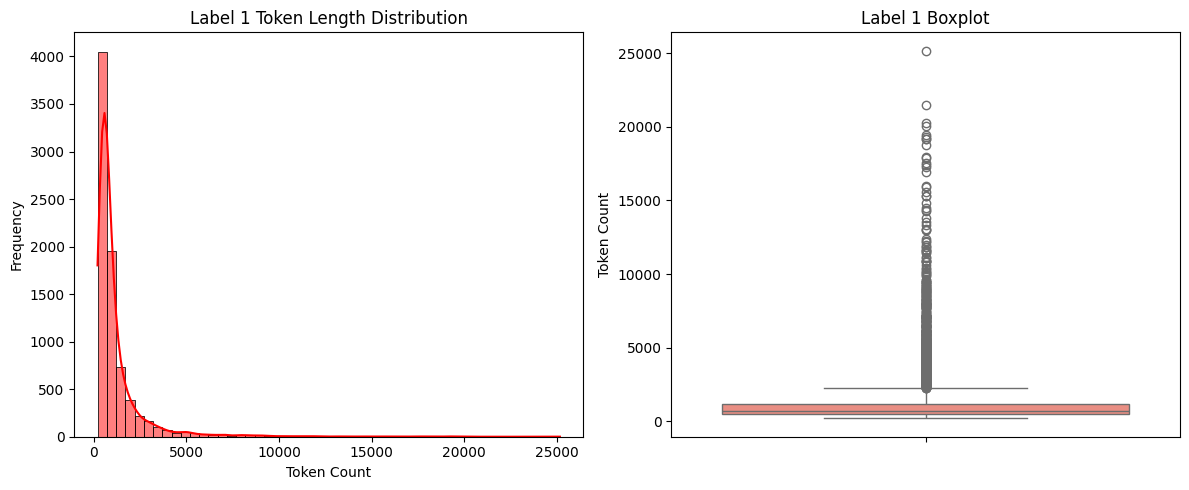

In [ ]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import AutoTokenizer
from tqdm import tqdm

# ==========================================
# [1] 설정
# ==========================================
BASE_DIR = 'data/interim/'
TRAIN_FILENAME = 'clean_train_balanced.csv'
MODEL_NAME = "monologg/koelectra-small-v3-discriminator"

# 분석할 라벨 (AI 데이터만 분석: 1, 사람이면 0)
TARGET_LABEL = 1 

# ==========================================
# [2] 메인 분석
# ==========================================
def main():
    print(f"Label {TARGET_LABEL} 데이터의 토큰 길이 분포 분석 시작...")
    
    # 1. 토크나이저 로드
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    
    # 토큰 길이를 저장할 리스트
    all_token_lengths = []
    
    # 2. 단일 파일 로드 (Fold 반복 제거)
    file_path = os.path.join(BASE_DIR, TRAIN_FILENAME)
    
    if os.path.exists(file_path):
        print(f" -> 파일 로드 중: {file_path}")
        df = pd.read_csv(file_path)
        
        # Label 필터링
        target_df = df[df['label'] == TARGET_LABEL].copy()
        texts = target_df['text'].astype(str).tolist()
        
        print(f" -> Label {TARGET_LABEL} 데이터 {len(texts)}개 토큰화 중...")
        
        # 토큰 개수 세기 (Truncation 없이 전체 길이 측정)
        for text in tqdm(texts):
            tokens = tokenizer(text, truncation=False, add_special_tokens=True)['input_ids']
            all_token_lengths.append(len(tokens))
            
    else:
        print(f"파일을 찾을 수 없습니다: {file_path}")
        return

    if not all_token_lengths:
        print("분석할 데이터가 없습니다.")
        return

    # 3. 통계 계산
    lengths = np.array(all_token_lengths)
    
    print("\n" + "="*50)
    print(f" [Label {TARGET_LABEL}] Token Length Statistics")
    print("="*50)
    print(f" 총 데이터 수 : {len(lengths):,} 개")
    print(f" 최소 길이     : {np.min(lengths):,} tokens")
    print(f" 최대 길이     : {np.max(lengths):,} tokens")
    print(f" 평균 길이     : {np.mean(lengths):.2f} tokens")
    print(f" 중앙값 (50%)  : {np.median(lengths):.2f} tokens")
    print("-" * 50)
    print(f" 상위 10% (90% 지점) : {np.percentile(lengths, 90):.2f} tokens")
    print(f" 상위 5%  (95% 지점) : {np.percentile(lengths, 95):.2f} tokens")
    print(f" 상위 1%  (99% 지점) : {np.percentile(lengths, 99):.2f} tokens")
    print("="*50)

    # 4. 시각화 (히스토그램 & Boxplot)
    plt.figure(figsize=(12, 5))

    # 히스토그램
    plt.subplot(1, 2, 1)
    sns.histplot(lengths, bins=50, kde=True, color='red')
    plt.title(f'Label {TARGET_LABEL} Token Length Distribution')
    plt.xlabel('Token Count')
    plt.ylabel('Frequency')

    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(y=lengths, color='salmon')
    plt.title(f'Label {TARGET_LABEL} Boxplot')
    plt.ylabel('Token Count')

    plt.tight_layout()
    save_path = 'label1_token_dist.png'
    plt.savefig(save_path)
    print(f"\n그래프 저장 완료: {save_path}")
    
    # Jupyter Notebook 환경이 아닌 경우 show() 호출
    # plt.show() 

if __name__ == "__main__":
    main()